# Oxygen Analysis Module

In [1]:
source('source.r')

Packages Loaded:
ncdf4 R.matlab openxlsx RColorBrewer compiler lattice geosphere readxl data.table rworldmap rworldxtra


Loading required package: ncdf4
Loading required package: R.matlab
Warning message:
"package 'R.matlab' was built under R version 3.4.3"R.matlab v3.6.1 (2016-10-19) successfully loaded. See ?R.matlab for help.

Attaching package: 'R.matlab'

The following objects are masked from 'package:base':

    getOption, isOpen

Loading required package: openxlsx
Warning message:
"package 'openxlsx' was built under R version 3.4.3"Loading required package: RColorBrewer
Loading required package: compiler
Loading required package: lattice
Warning message:
"package 'lattice' was built under R version 3.4.3"Loading required package: geosphere
Warning message:
"package 'geosphere' was built under R version 3.4.3"Loading required package: readxl
Loading required package: data.table
Warning message:
"package 'data.table' was built under R version 3.4.3"Loading required package: rworldmap
Warning message:
"package 'rworldmap' was built under R version 3.4.3"Loading required package: sp
Warning message:
"

In [2]:
O2sol = function(S, T) {
    # convert T to scaled temperature
    temp_S = log((298.15 - T) / (273.15 + T))

    # constants from Table 1 of Garcia & Gordon for the fit to Benson and Krause (1984)
    A0_o2 = 5.80871
    A1_o2 = 3.20291
    A2_o2 = 4.17887
    A3_o2 = 5.10006
    A4_o2 = -9.86643e-2
    A5_o2 = 3.80369
    B0_o2 = -7.01577e-3
    B1_o2 = -7.70028e-3
    B2_o2 = -1.13864e-2
    B3_o2 = -9.51519e-3
    C0_o2 = -2.75915e-7

    # Corrected Eqn (8) of Garcia and Gordon 1992 (umol / kg)
    exp(A0_o2 + A1_o2*temp_S + A2_o2*temp_S^2 + A3_o2*temp_S^3 + A4_o2*temp_S^4 + A5_o2*temp_S^5 + 
        S*(B0_o2 + B1_o2*temp_S +B2_o2*temp_S^2 + B3_o2*temp_S^3) + C0_o2*S^2)
}

## Load the ship data

In [4]:
load('RStates/ship.final.2min.rdata')

In [12]:
#summary(ship.data$OS)  # mg/L
#summary(ship.data$OX)  # mg/L
summary(ship.data$OS / ship.data$OX * 100) # % sat
summary(ship.data$Optode.ch1)  # % sat
summary(ship.data$Optode.ch2)  # % sat
#summary(ship.data$Optode.ch3)  # mixed
#summary(ship.data$Optode.ch4)  # uM
#summary(ship.data$EIMS.O2)  # uM
summary(ship.data$EIMS.O2.sat)  # % sat
#summary(ship.data$EIMS.O2.cal)  # uM
summary(ship.data$EIMS.O2.sat.cal)  # % sat

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 -12.89   97.68  101.58  102.19  106.09  213.16 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.1124 101.2013 103.6967 103.5134 108.1333 141.1056 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.5716  99.2397 101.7494 101.1546 106.0000 133.2500 

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
  0.2267 104.8772 107.6731 107.5891 110.9337 148.2267 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    0.0   104.2   107.2   106.9   111.5   131.4 

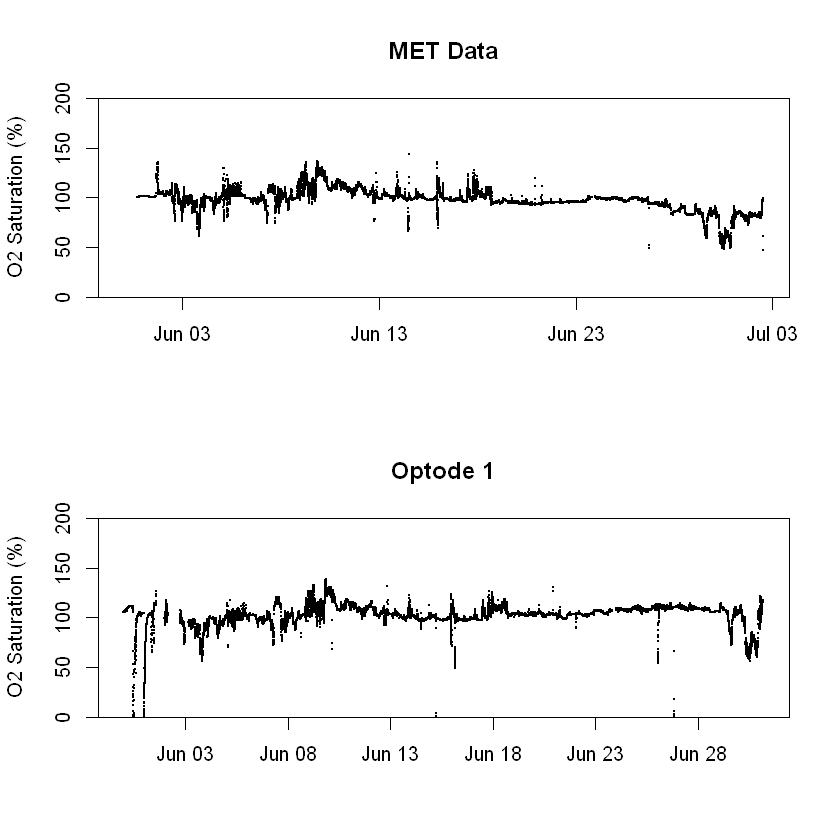

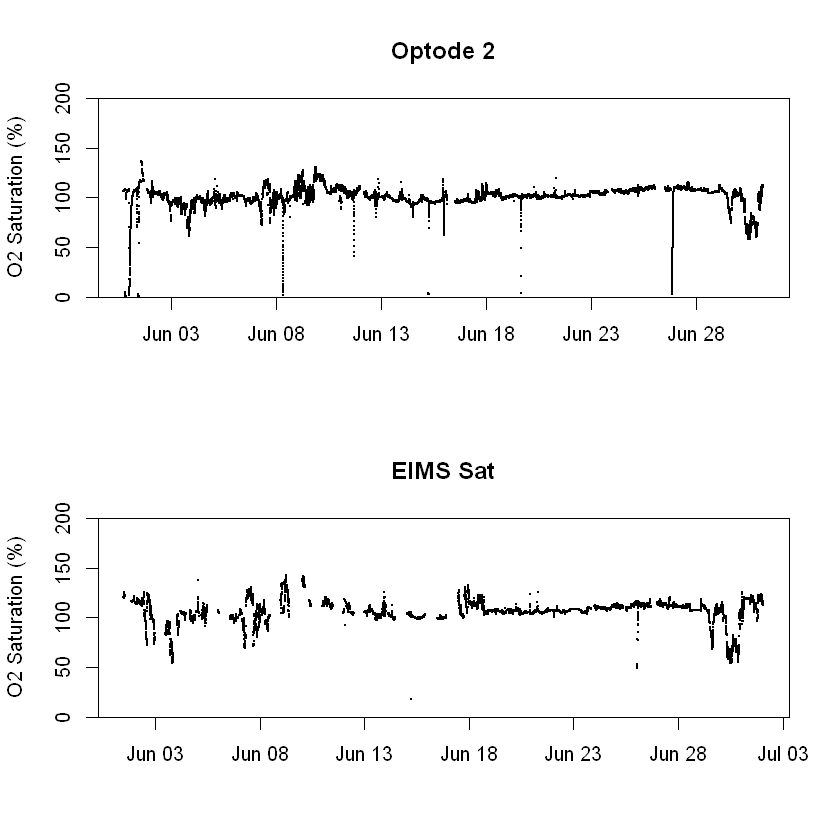

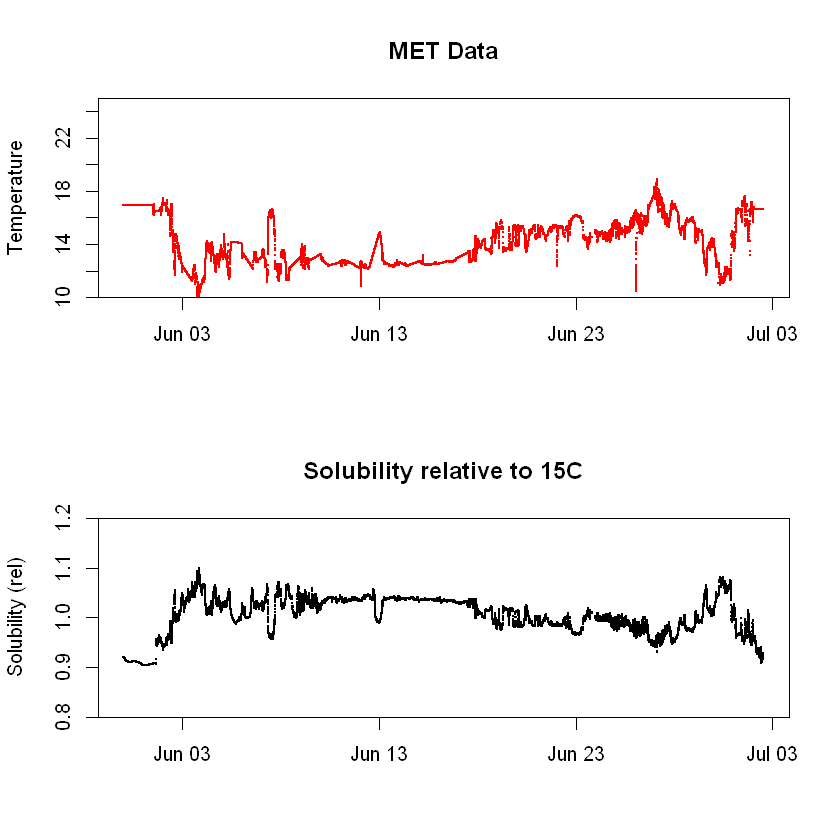

In [41]:
#pdf('Output/Oxygen Analysis - Oxygen solubility and Temperature Dependence.pdf')
#png('Output/Oxygen Analysis - Oxygen solubility and Temperature Dependence.png')

par(mfrow=c(2,1))
plot(ship.data$DT, ship.data$OX / ship.data$OS * 100, pch=20, cex=0.1, ylab='O2 Saturation (%)', xlab='',
     yaxs='i', ylim=c(0,200), main='MET Data')

l = ship.data$Optode.ch1.FLAG == 1
plot(ship.data$DT[l], ship.data$Optode.ch1[l] * O2sol(S = 35, T = 15) / O2sol(S = 35, T = ship.data$TT[l]),
     pch=20, cex=0.1, ylab='O2 Saturation (%)', xlab='', yaxs='i', ylim=c(0,200), main='Optode 1')

l = ship.data$MIMS.O2.Ar.FLAG == 1
plot(ship.data$DT[l], ship.data$Optode.ch2[l] * O2sol(S = 35, T = 15) / O2sol(S = 35, T = ship.data$TT[l]),
     pch=20, cex=0.1, ylab='O2 Saturation (%)', xlab='', yaxs='i', ylim=c(0,200), main='Optode 2')

l = ship.data$EIMS.O2.sat.FLAG == 1
plot(ship.data$DT[l], ship.data$EIMS.O2.sat[l] * O2sol(S = 35, T = 15) / O2sol(S = 35, T = ship.data$TT[l]),
     pch=20, cex=0.1, ylab='O2 Saturation (%)', xlab='', yaxs='i', ylim=c(0,200), main='EIMS Sat')

plot(ship.data$DT, ship.data$EIMS.Inlet.T, pch=20, cex=0.1, ylab='Temperature', xlab='', yaxs='i', ylim=c(10,25),
     main='MET Data', col='red')

plot(ship.data$DT, O2sol(S = 35, T = ship.data$TT) / O2sol(S = 35, T = 15), pch=20, cex=0.1, ylim=c(0.8, 1.2),
     ylab='Solubility (rel)', yaxs='i', xlab='', main='Solubility relative to 15C')

#dev.off()

## Load the Winkler data

In [5]:
winkler = read.xlsx('Raw Data/Winkler/Winkler O2 data CCE cruise.xlsx')
str(winkler)

'data.frame':	27 obs. of  15 variables:
 $ X1         : num  1 2 3 4 5 6 7 8 9 10 ...
 $ Bottle#    : num  1309 1841 1703 693 1840 ...
 $ temp       : num  13.6 14.3 14.4 14.4 13.4 13.4 13.3 13.3 13.7 13.7 ...
 $ ml/l       : num  6.22 5.9 7.65 7.67 6.45 ...
 $ date       : num  42891 42892 43625 43625 42899 ...
 $ time       : chr  NA "0.49305555555555558" NA NA ...
 $ station    : chr  "underway" "underway" "underway" "underway" ...
 $ long       : chr  "36.08.5637N" "34.50.66N" "35.03.529" "35.03.529" ...
 $ lat        : chr  "123.08.1362W" "122.19.3871W" "121.07.1770W" "121.07.1770W" ...
 $ O2.EIMS.%  : num  102 101 140 140 111 ...
 $ temp.EIMS  : chr  NA NA NA NA ...
 $ O2.MIMS    : num  NA NA NA NA NA NA NA NA NA NA ...
 $ O2conc.MIMS: num  NA NA NA NA NA NA NA NA NA NA ...
 $ temp.MIMS  : num  NA NA NA NA NA NA NA NA NA NA ...
 $ otes       : chr  "from main lab water supply" "from main lab water supply" "from main lab water supply" "from hydro lab flowthrough" ...


In [6]:
head(winkler)

X1,Bottle#,temp,ml/l,date,time,station,long,lat,O2.EIMS.%,temp.EIMS,O2.MIMS,O2conc.MIMS,temp.MIMS,otes
1,1309,13.6,6.224,42891,NA,underway,36.08.5637N,123.08.1362W,102.00,NA,NA,NA,NA,from main lab water supply
2,1841,14.3,5.897,42892,0.49305555555555558,underway,34.50.66N,122.19.3871W,100.90,NA,NA,NA,NA,from main lab water supply
3,1703,14.4,7.650,43625,NA,underway,35.03.529,121.07.1770W,140.00,NA,NA,NA,NA,from main lab water supply
4,693,14.4,7.666,43625,NA,underway,35.03.529,121.07.1770W,140.00,NA,NA,NA,NA,from hydro lab flowthrough
5,1840,13.4,6.446,42899,0.39583333333333337,underway,34.43.9803N,121.42.4288W,110.73,NA,NA,NA,NA,from hydro lab flowthrough
6,1797,13.4,6.458,42899,0.39583333333333337,underway,34.43.9803N,121.42.4288W,110.62,NA,NA,NA,NA,bubbles in MgCl/water from hydrolab


In [7]:
winkler$time = conv_excel_time(as.numeric(winkler$time) + as.numeric(winkler$date))

Warning message in as.Date(x, origin = origin, tz = tz):
“NAs introduced by coercion”

In [8]:
nrow(winkler)
winkler = winkler[!is.na(winkler$time),]
nrow(winkler)

[1] 27

[1] 19

In [9]:
summary(O2sol(ship.data$SA, ship.data$TT))/32

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
7.090625 7.709375 7.909375 7.868750 8.106250 8.603125 

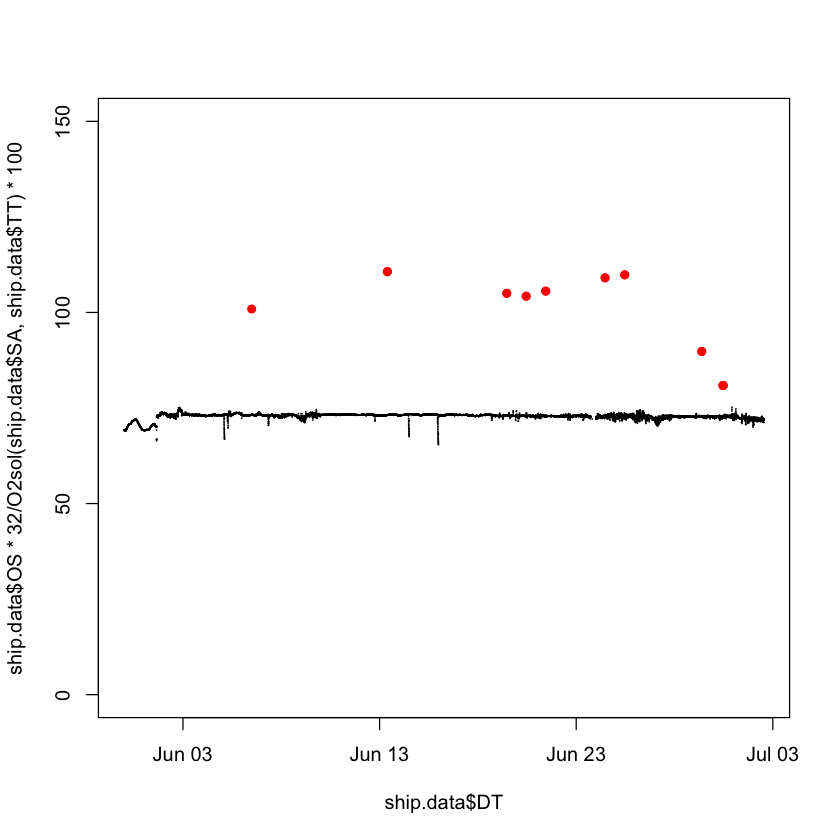

In [10]:
plot(ship.data$DT, ship.data$OS * 32 / O2sol(ship.data$SA, ship.data$TT) * 100, pch=16, cex=0.2, ylim=c(0,150)) # mmol / L
points(winkler$time, winkler$'O2.EIMS.%', col='red', pch=16)